In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.neural_network import MLPClassifier
from classifier import MLPBinary
import utils

L = 10
T_CRIT = 2.2691853

In [6]:
# resizing of the data created with monte carlo

lt, ut, t_step = 1.0, 3.2, 0.003

#for L in [10, 15, 20]:
 #   utils.resize_data(L, lt, ut)
    
utils.resize_data_test(10)

EmptyDataError: No columns to parse from file

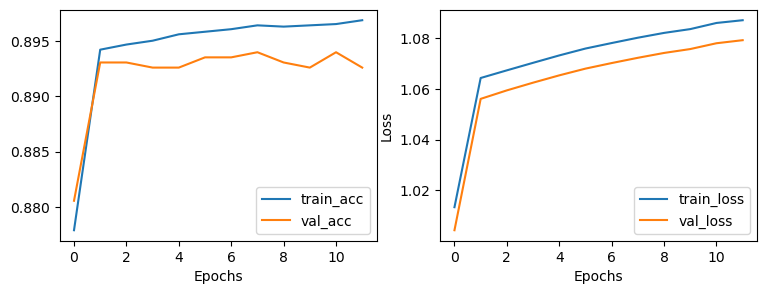

In [12]:
# CLASSIFIER TRAINING
data_train, t_train, data_val, t_val, data_test, t_test = utils.load_train_data(10, mode = 'all')

clf = MLPBinary(dim_hidden=100, tolerance=1e-5, activation='relu', lr=0.01, batch_size=200, momentum=0.9, solver='sgd', alpha=0.001, power_t=0.4, n_epochs_no_update=5, symmetric_weights=True)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,3))
E = len(clf.train_acc) 
ax1.plot(np.arange(E), clf.train_acc)
ax1.plot(np.arange(E), clf.val_acc)
ax1.legend(["train_acc", "val_acc"])

ax2.plot(np.arange(E), clf.train_loss)
ax2.plot(np.arange(E), clf.val_loss)
ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])

(array([158., 602., 560., 549., 505., 547., 563., 543., 555., 515., 542.,
        512., 532., 587., 527., 529., 517., 550., 546., 161.]),
 array([-0.21297164, -0.19160333, -0.17023501, -0.1488667 , -0.12749838,
        -0.10613007, -0.08476176, -0.06339344, -0.04202513, -0.02065681,
         0.0007115 ,  0.02207981,  0.04344813,  0.06481644,  0.08618476,
         0.10755307,  0.12892138,  0.1502897 ,  0.17165801,  0.19302633,
         0.21439464]),
 <BarContainer object of 20 artists>)

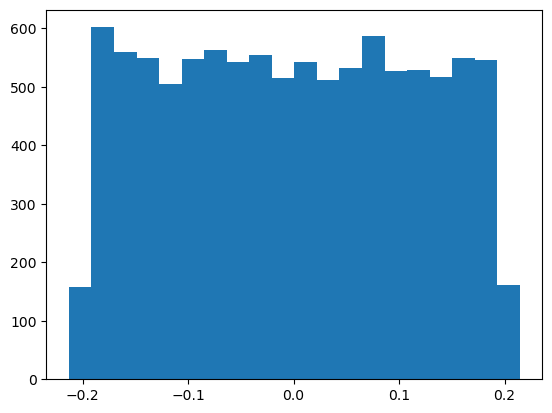

In [13]:
a = clf.weights1.flatten()
plt.hist(a, 20)

In [ ]:
b = clf.weights2.flatten()
b @ b.T

6.746476036426959

In [4]:
# accuracy test on data w/wo 
# loading data for testing
data_test = np.load(f"./data/{L}_test.npy").reshape(-1, L*L)
temp_test = np.load(f"./data/{L}_test_temp.npy").reshape(-1,)

t_test = (temp_test > T_CRIT).astype(int)

    
# sort data into ascending order according to temperatures
# potrei metterlo in utils
min_bound = 2.2
max_bound = 2.3

mask = (temp_test > max_bound) | (temp_test < min_bound)   

print(f"Outer data accuracy: {clf.score(data_test[mask], t_test[mask])}")
print(f"Inner data accuracy: {clf.score(data_test[~mask], t_test[~mask])}")


Outer data accuracy: 0.9045454545454545
Inner data accuracy: 0.75


In [14]:
print(clf.score(data_M_null, t_M_null))
print(clf.score(data_M_pos, t_M_pos))
print(clf.score(data_M_neg, t_M_neg))

0.607773851590106
0.9812409812409812
0.9897715649505625


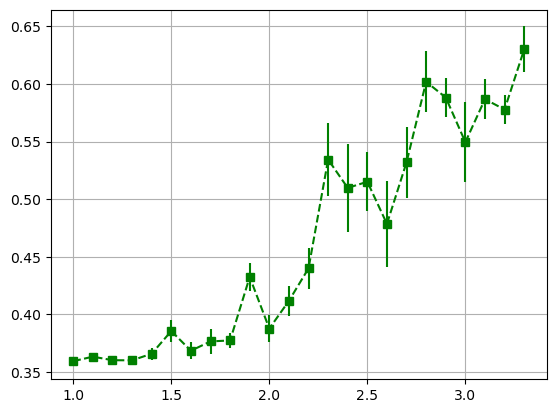

In [ ]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_probabilities(flattened).reshape(10, 24, 1)
errors = y[:,:,0].std(axis=0) / np.sqrt(10)
plt.errorbar(temp_test[3], y[:,:,0].mean(axis=0), errors, fmt='s--g')
plt.grid(True)


## Accuracy vs layer size

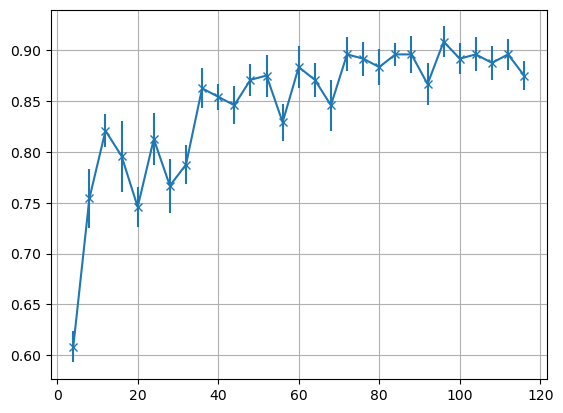

In [ ]:
import pandas as pd
df = pd.read_csv("accuracy - dimensions.csv")
x = df['dim_hidden']
y = df['acc mean']
err = df['acc std']

plt.errorbar(x, y, err, marker='x')
plt.grid(True)


### Training con differenti magnetitzzazioni

In [ ]:
# questo per il training
data = np.load(f"data/{L}_test_tanti.npy").reshape(-1, 100)
temp = np.load(f"data/{L}_temp_tanti.npy").reshape(-1,)
n = data.shape[0]
# target value
t = (temp > T_CRIT).astype(int)

mask = ((temp < T_CRIT) & (np.sum(data, axis=1) > 0)) # mask for positive M and t < T_crit
data_M_pos = data[mask]
t_M_pos = t[mask]

mask = ((temp < T_CRIT) & (np.sum(data, axis=1) < 0)) # mask for negative M and t < T_crit
data_M_neg = data[mask]
t_M_neg = t[mask]

data_M_null = data[temp > T_CRIT]
t_M_null = t[temp > T_CRIT]

# dati di test separati per magnetizzazione | devo anche prendere le temperature ordinate correttamente -> che so la label
# al momento solo su un set di temperature
data_test = np.load(f"./data/{L}_test.npy").reshape(10, 24, L*L)
temp_test = np.load(f"./data/{L}_test_temp.npy").reshape(10, 24)

index = np.argsort(temp_test, axis=1)
temp_test = np.sort(temp_test, axis=1)
index_expanded = index[..., np.newaxis]
data_test = np.take_along_axis(data_test, index_expanded, axis=1)

slices = np.array([data_test[:, i, :] for i in range(24)])
temp_test = np.array([temp_test[:, i] for i in range(24)])

mask = (temp_test > T_CRIT).astype(int)
data_test_M_null = slices[13:, :]
temp_test_M_null = temp_test[13:,0]
t_test_M_null = np.ones(11)

data_bassi = slices[:13,:]

mask = (np.sum(data_bassi, axis=2) > 0)
data_test_M_pos = [data_bassi[i][mask[i]] for i in range(data_bassi.shape[0])]
temp_test_M_pos = temp_test[:13,0]
t_test_M_pos = np.zeros(13)

mask = (np.sum(data_bassi, axis=2) < 0)
data_test_M_neg = [data_bassi[i][mask[i]] for i in range(data_bassi.shape[0])]
temp_test_M_neg = temp_test[:13,0]
t_test_M_neg = np.zeros(13)

'mask = ((temp_test < T_CRIT) & (np.sum(slices, axis=2) > 0)) | (temp_test > T_CRIT)\ndata_test_M_pos = slices[mask]\ntemp_test_M_pos = np.array([1.1, 1.2, 1.4, 1.5, 1.9, 2.1, 2.2, 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3])\nt_test_M_pos = (temp_test_M_pos > T_CRIT).astype(int)\n\nmask = ((temp_test < T_CRIT) & (np.sum(slices, axis=2) < 0)) | (temp_test > T_CRIT)\ndata_test_M_neg = slices[mask]\ntemp_test_M_neg = np.array([1. , 1.3, 1.6, 1.7, 1.8, 2. , 2.3, 2.4, 2.5, 2.6, 2.7, 2.8, 2.9,\n       3. , 3.1, 3.2, 3.3])\nt_test_M_neg = (temp_test_M_pos > T_CRIT).astype(int)'

In [240]:
t_test_M_null.shape

(11,)

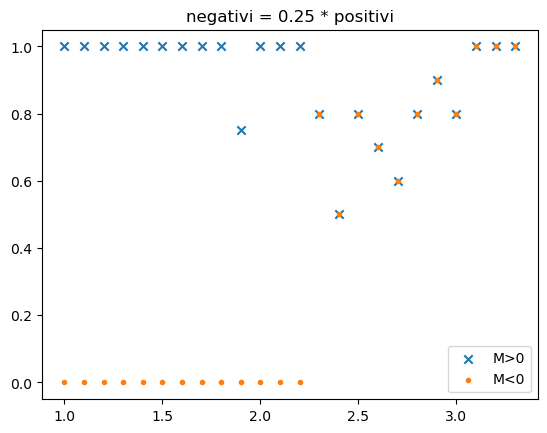

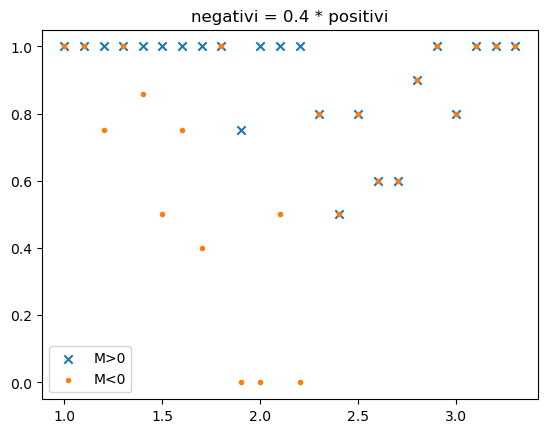

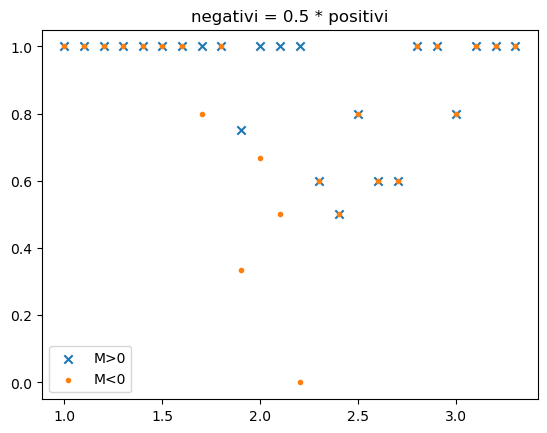

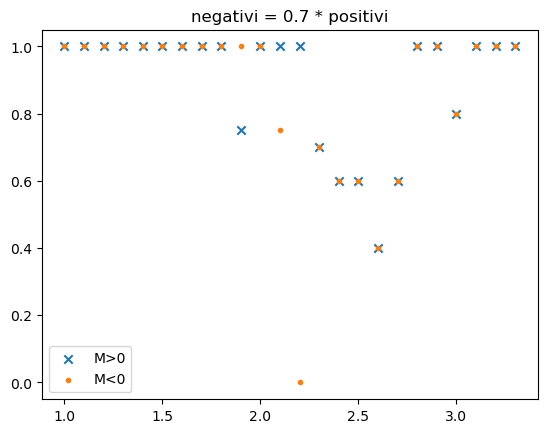

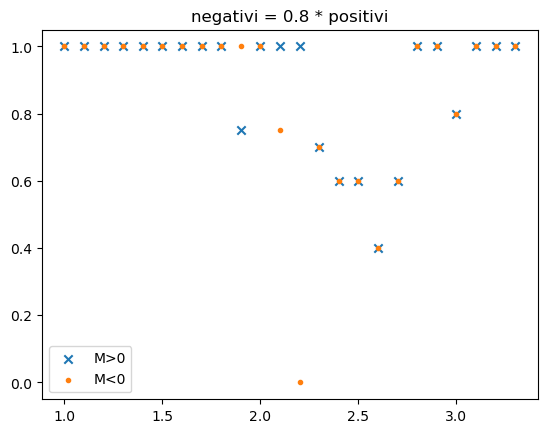

In [ ]:
for f in [0.25, 0.4, 0.5, 0.7, 0.8, 1]:
    a, b, c = 0, int(f*A), int((1+f)*A)
    z = np.concatenate((data_M_pos, data_M_neg[:b], data_M_null[:c]))
    zz = np.concatenate((t_M_pos, t_M_neg[:b], t_M_null[:c]))
    data_val = data_M_neg
    t_val = t_M_neg

    data_train, t_train, _, _ = utils.get_training_data(z, zz, 0)

    clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.01, batch_size=200, momentum=0.8, solver='sgd', alpha=0.1, power_t=0.3, n_epochs_no_update=5)
    clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

    acc_pos = [clf.score(data_test_M_pos[i], t_test_M_pos[i]) for i in range(13)]
    acc_neg = [clf.score(data_test_M_neg[i], t_test_M_neg[i]) for i in range(13)]
    acc_null = [clf.score(data_test_M_null[i, :,:], t_test_M_null[i]) for i in range(11)]
    temps = np.arange(1, 3.4, 0.1)
    
    plt.figure()
    plt.scatter(temps, acc_pos + acc_null, marker='x')
    plt.scatter(temps, acc_neg + acc_null, marker='.')
    plt.legend(['M>0', 'M<0'])
    plt.title(f'negativi = {f} * positivi')
    plt.show()

In [ ]:
f=1    
A = 
a, b, c = 0, int(f*A), int((1+f)*A)
z = np.concatenate((data_M_pos, data_M_neg[:b], data_M_null[:c]))
zz = np.concatenate((t_M_pos, t_M_neg[:b], t_M_null[:c]))
data_val = data_M_neg
t_val = t_M_neg

data_train, t_train, _, _ = utils.get_training_data(z, zz, 0)

clf = MLPBinary(dim_hidden=100, tolerance=1e-4, activation='relu', lr=0.01, batch_size=200, momentum=0.8, solver='sgd', alpha=0.1, power_t=0.3, n_epochs_no_update=5)
clf.fit(data_train, t_train, X_val=data_val, t_val=t_val)

acc_pos = [clf.score(data_test_M_pos[i], t_test_M_pos[i]) for i in range(13)]
acc_neg = [clf.score(data_test_M_neg[i], t_test_M_neg[i]) for i in range(13)]
acc_null = [clf.score(data_test_M_null[i, :,:], t_test_M_null[i]) for i in range(11)]
temps = np.arange(1, 3.4, 0.1)

plt.figure()
plt.scatter(temps, acc_pos + acc_null, marker='x')
plt.scatter(temps, acc_neg + acc_null, marker='.')
plt.legend(['M>0', 'M<0'])
plt.title(f'negativi = {f} * positivi')
plt.show()

NameError: name 'A' is not defined

In [99]:
clf.score(data_M_neg, t_M_neg)

0.9041936583702693

## SKLEARN

c:\Users\CrisMattGiov\miniconda3\envs\in3050\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


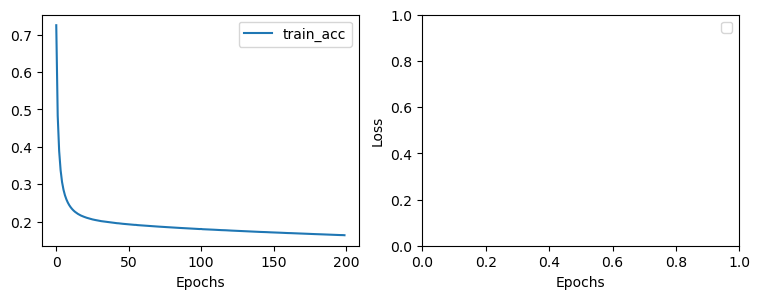

In [104]:
# training with sklearn

# using skleanr
clf = MLPClassifier(activation='relu', solver='sgd',alpha=0, momentum=0.9, nesterovs_momentum=False,  verbose=False)
clf.fit(data_train, t_train)

# plotting accuracy and loss
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2, figsize=(9,3))


E = len(clf.loss_curve_) 
ax1.plot(np.arange(E), clf.loss_curve_)

ax1.legend(["train_acc", "val_acc"])

ax2.set_ylabel("Loss"), ax2.set_xlabel("Accuracy")
ax1.set_xlabel("Epochs"), ax2.set_xlabel("Epochs")
ax2.legend(["train_loss", "val_loss"])


(array([1., 2., 2., 4., 2., 4., 5., 6., 1., 7., 5., 2., 2., 4., 2., 1., 5.,
        4., 4., 2., 4., 8., 2., 5., 5., 4., 4., 2., 0., 1.]),
 array([-0.32493354, -0.29496952, -0.2650055 , -0.23504148, -0.20507746,
        -0.17511344, -0.14514942, -0.11518541, -0.08522139, -0.05525737,
        -0.02529335,  0.00467067,  0.03463469,  0.06459871,  0.09456273,
         0.12452675,  0.15449077,  0.18445479,  0.21441881,  0.24438283,
         0.27434685,  0.30431086,  0.33427488,  0.3642389 ,  0.39420292,
         0.42416694,  0.45413096,  0.48409498,  0.514059  ,  0.54402302,
         0.57398704]),
 <BarContainer object of 30 artists>)

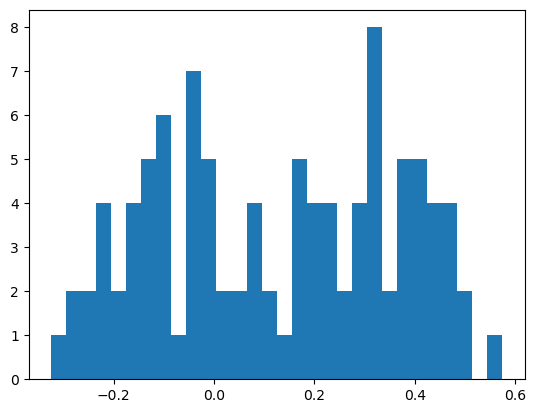

In [107]:
a = clf.coefs_[1].flatten()
n_bins = 30
plt.hist(a, n_bins)

In [14]:
b = clf.coefs_[0]
np.sum(b * b, axis=1)

0.1634691189926141

In [18]:
clf.score(data_test[3], t_test[0])

1.0

In [ ]:
# PREDICTION ON DATA SET to have mean
flattened = data_test.reshape(-1, L*L)
y = clf.predict_proba(flattened).reshape(10,-1, 2)

In [ ]:
y.shape

In [ ]:
train_size = 10
errors = y[:,:,1].std(axis=0, ddof=1) / np.sqrt(train_size)  # std/(N-1)
plt.errorbar(temp_test[3], y[:,:,1].mean(axis=0), errors, fmt='s--g')

plt.grid(True)

In [ ]:
out = clf.predict_proba(data_val)
plt.scatter(temp[a:], out[:,1], marker='x', c=clf.predict(data_val) )
plt.vlines(T_CRIT, 0, 1)